In [13]:
import os, sys
import logging
import json
import glob
import importlib
import math

import torch

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
#############

SRC_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "protdiff"
)
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import datasets
import plotting
import sampling
import utils

BIN_DIR = os.path.join(
    os.path.dirname(os.getcwd()), "bin"
)
assert os.path.isdir(BIN_DIR)
sys.path.append(BIN_DIR)
import sample as sample_bin

logging.basicConfig(level=logging.INFO)

Load in dataset of proteins and get the natural distribution of angles

In [2]:
# Best model for linear variance schedule
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models_initial/1000_timesteps_linear_variance_schedule_64_batch_size_0.0001_lr_0.5_gradient_clip"
# Best model for cosine variance schedule
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models/250_timesteps_cosine_variance_schedule_128_batch_size_0.0001_lr_0.5_gradient_clip"
# Model with radian loss
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models/results"
# MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models/shifted_noise_test"
MODEL_DIR = "/home/t-kevinwu/projects/protein_diffusion/models/temp"

with open(os.path.join(MODEL_DIR, "training_args.json")) as source:
    params = json.load(source)
params

{'results_dir': 'temp',
 'shift_angles_zero_twopi': True,
 'noise_prior': 'gaussian',
 'timesteps': 1000,
 'variance_schedule': 'linear',
 'adaptive_noise_mean_var': True,
 'num_hidden_layers': 6,
 'hidden_size': 72,
 'intermediate_size': 144,
 'num_heads': 8,
 'gradient_clip': 0.5,
 'lr': 0.001,
 'loss': 'radian_l1_smooth',
 'l2_norm': 0.01,
 'l1_norm': 0.0,
 'epochs': 200,
 'early_stop_patience': 5,
 'toy': False,
 'batch_size': 64,
 'multithread': True}

In [3]:
cath_dset = datasets.CathConsecutiveAnglesDataset(
    split='train',
    shift_to_zero_twopi=params['shift_to_zero_twopi'] if 'shift_to_zero_twopi' in params else True,
    toy=False
)
len(cath_dset)

INFO:root:Split train contains 18024/21668 examples
INFO:root:Removed structures with nan 18024 -> 12673
INFO:root:Length of angles: 39-499, mean 199.41324074804703


12673

In [4]:
select_by_attn = lambda x: x['angles'][torch.where(x['attn_mask'])]

cath_dset_values = torch.vstack([select_by_attn(cath_dset[i]) for i in range(len(cath_dset))])
cath_dset_values.shape

torch.Size([2527164, 4])

In [5]:
torch.max(cath_dset_values, axis=0).values, torch.min(cath_dset_values, axis=0).values

(tensor([45.4163,  6.2832,  6.2832,  5.8658]),
 tensor([1.3404e+00, 1.1428e-07, 5.9129e-05, 3.1565e+00]))

Generate some proteins

INFO:root:Getting linear variance schedule with 1000 timesteps


  0%|          | 0/12673 [00:00<?, ?it/s]

  0%|          | 0/12673 [00:00<?, ?it/s]

  0%|          | 0/12673 [00:00<?, ?it/s]

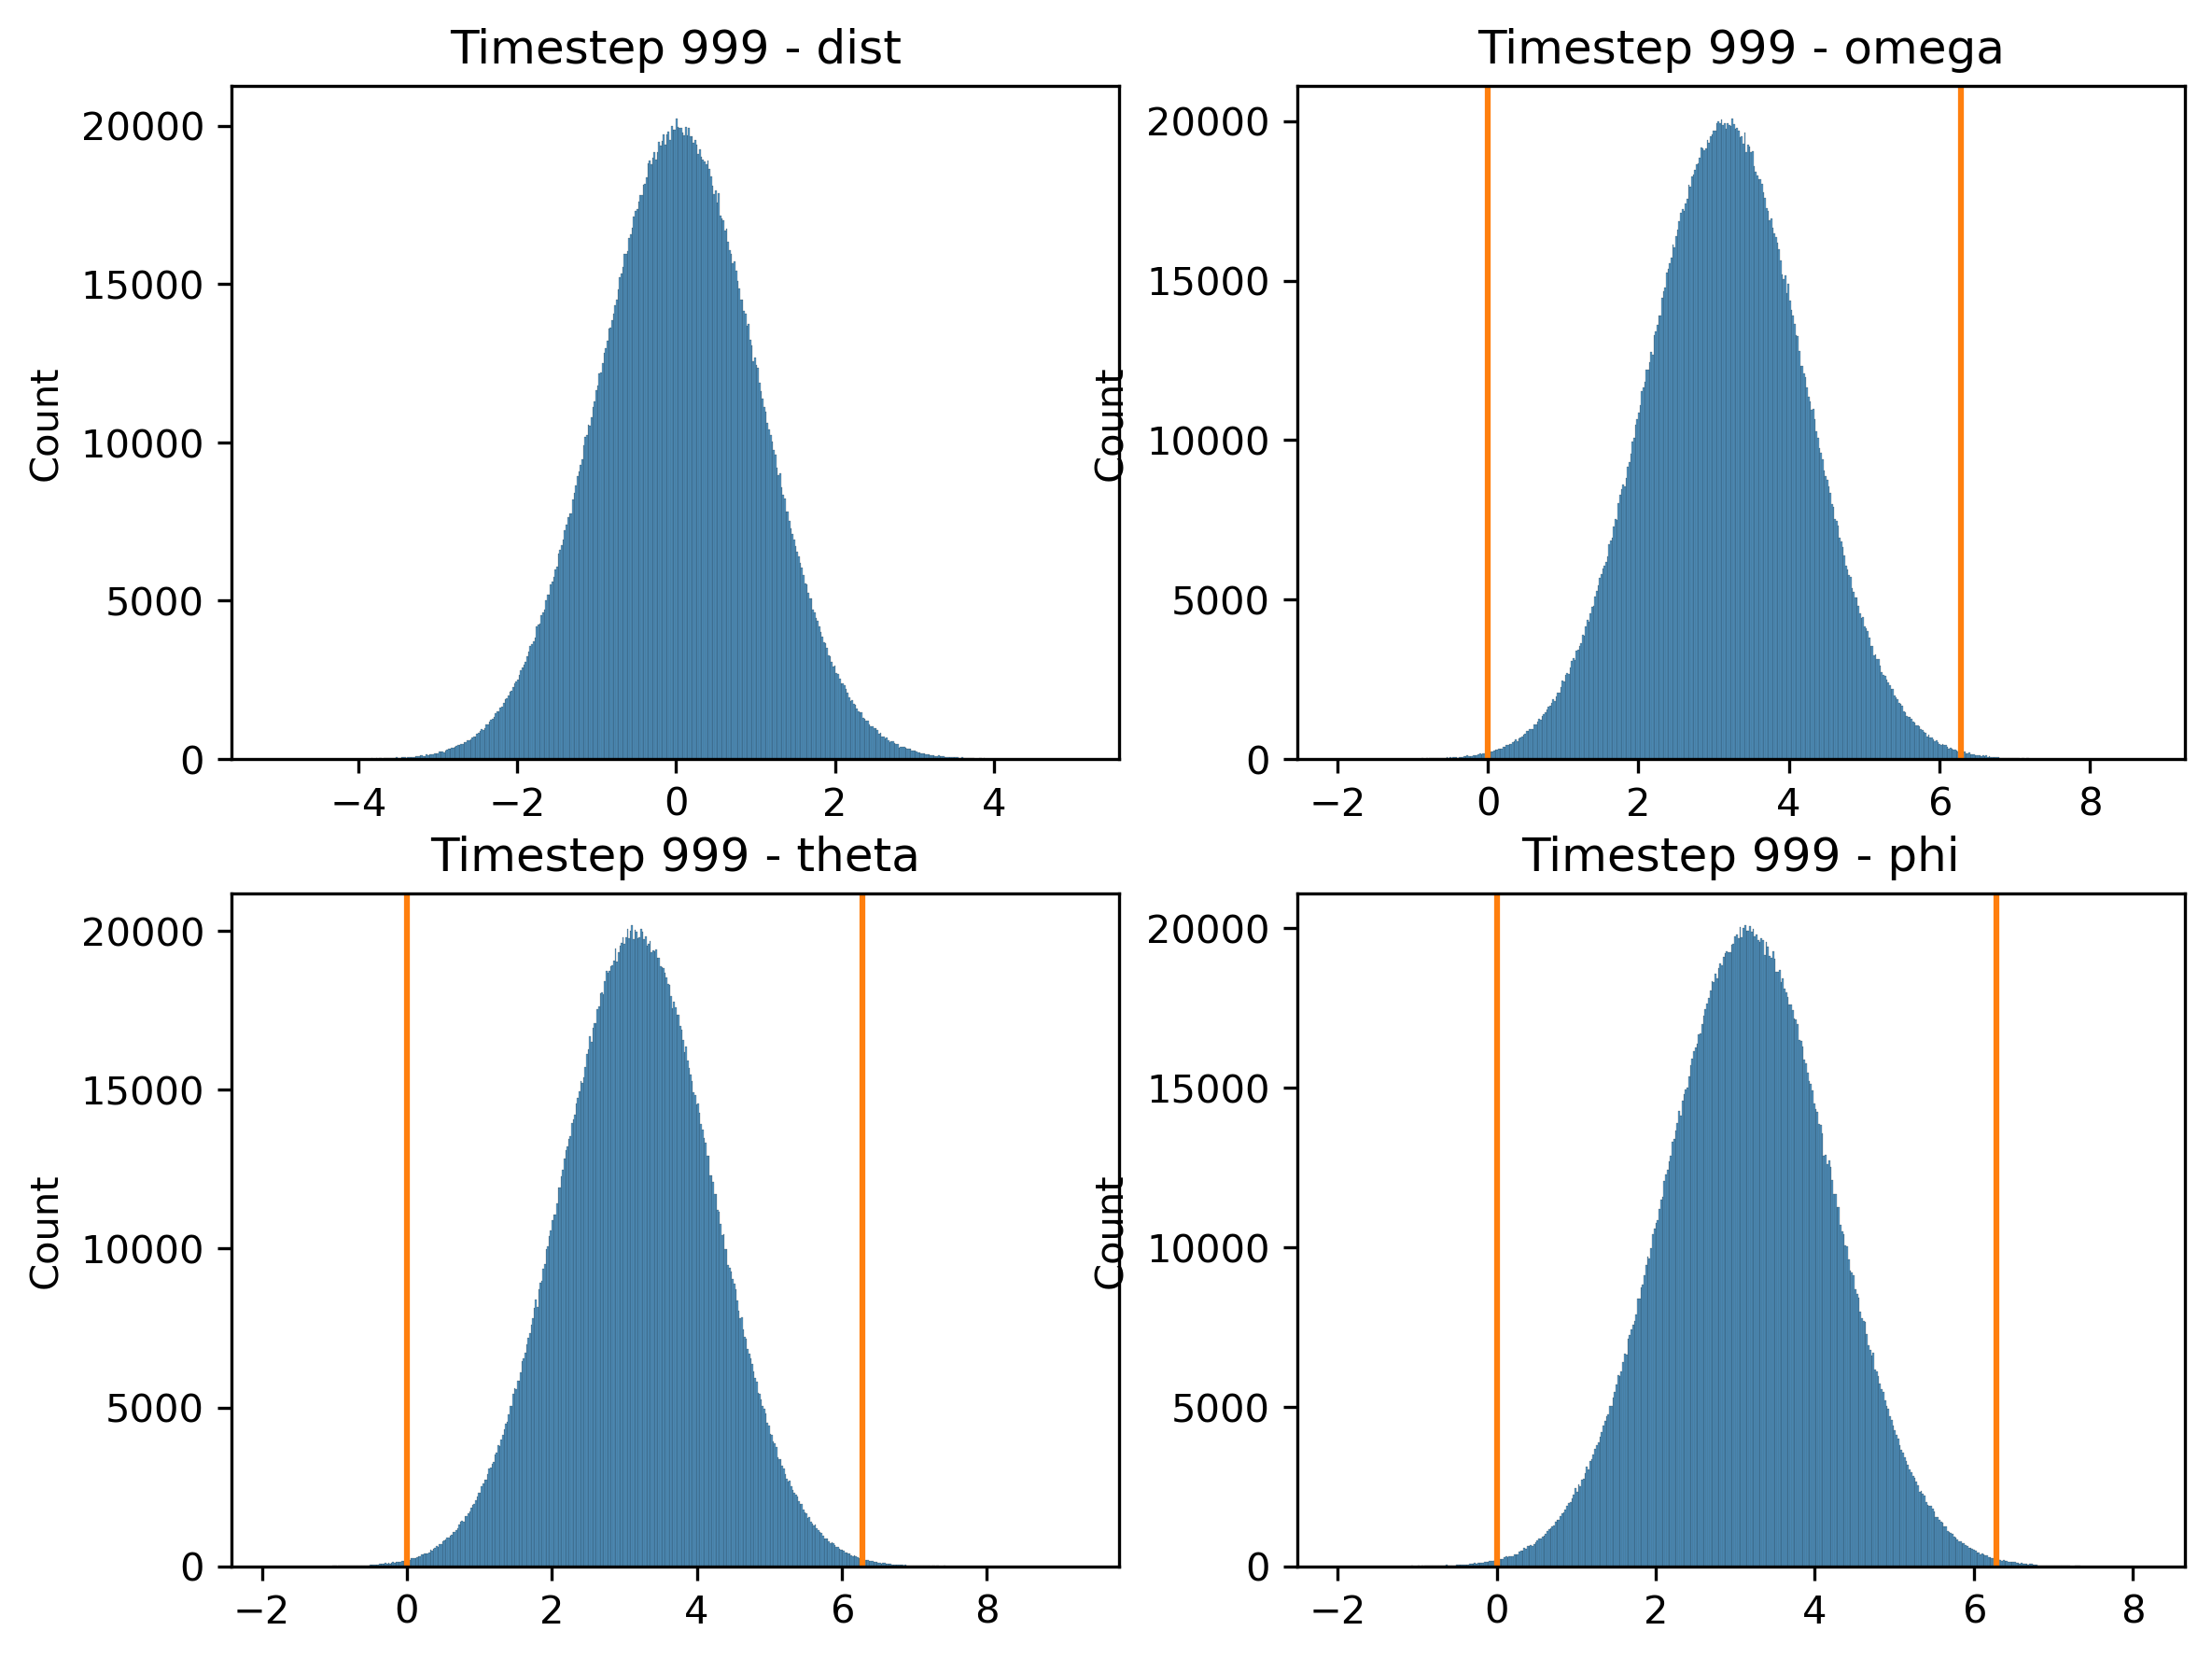

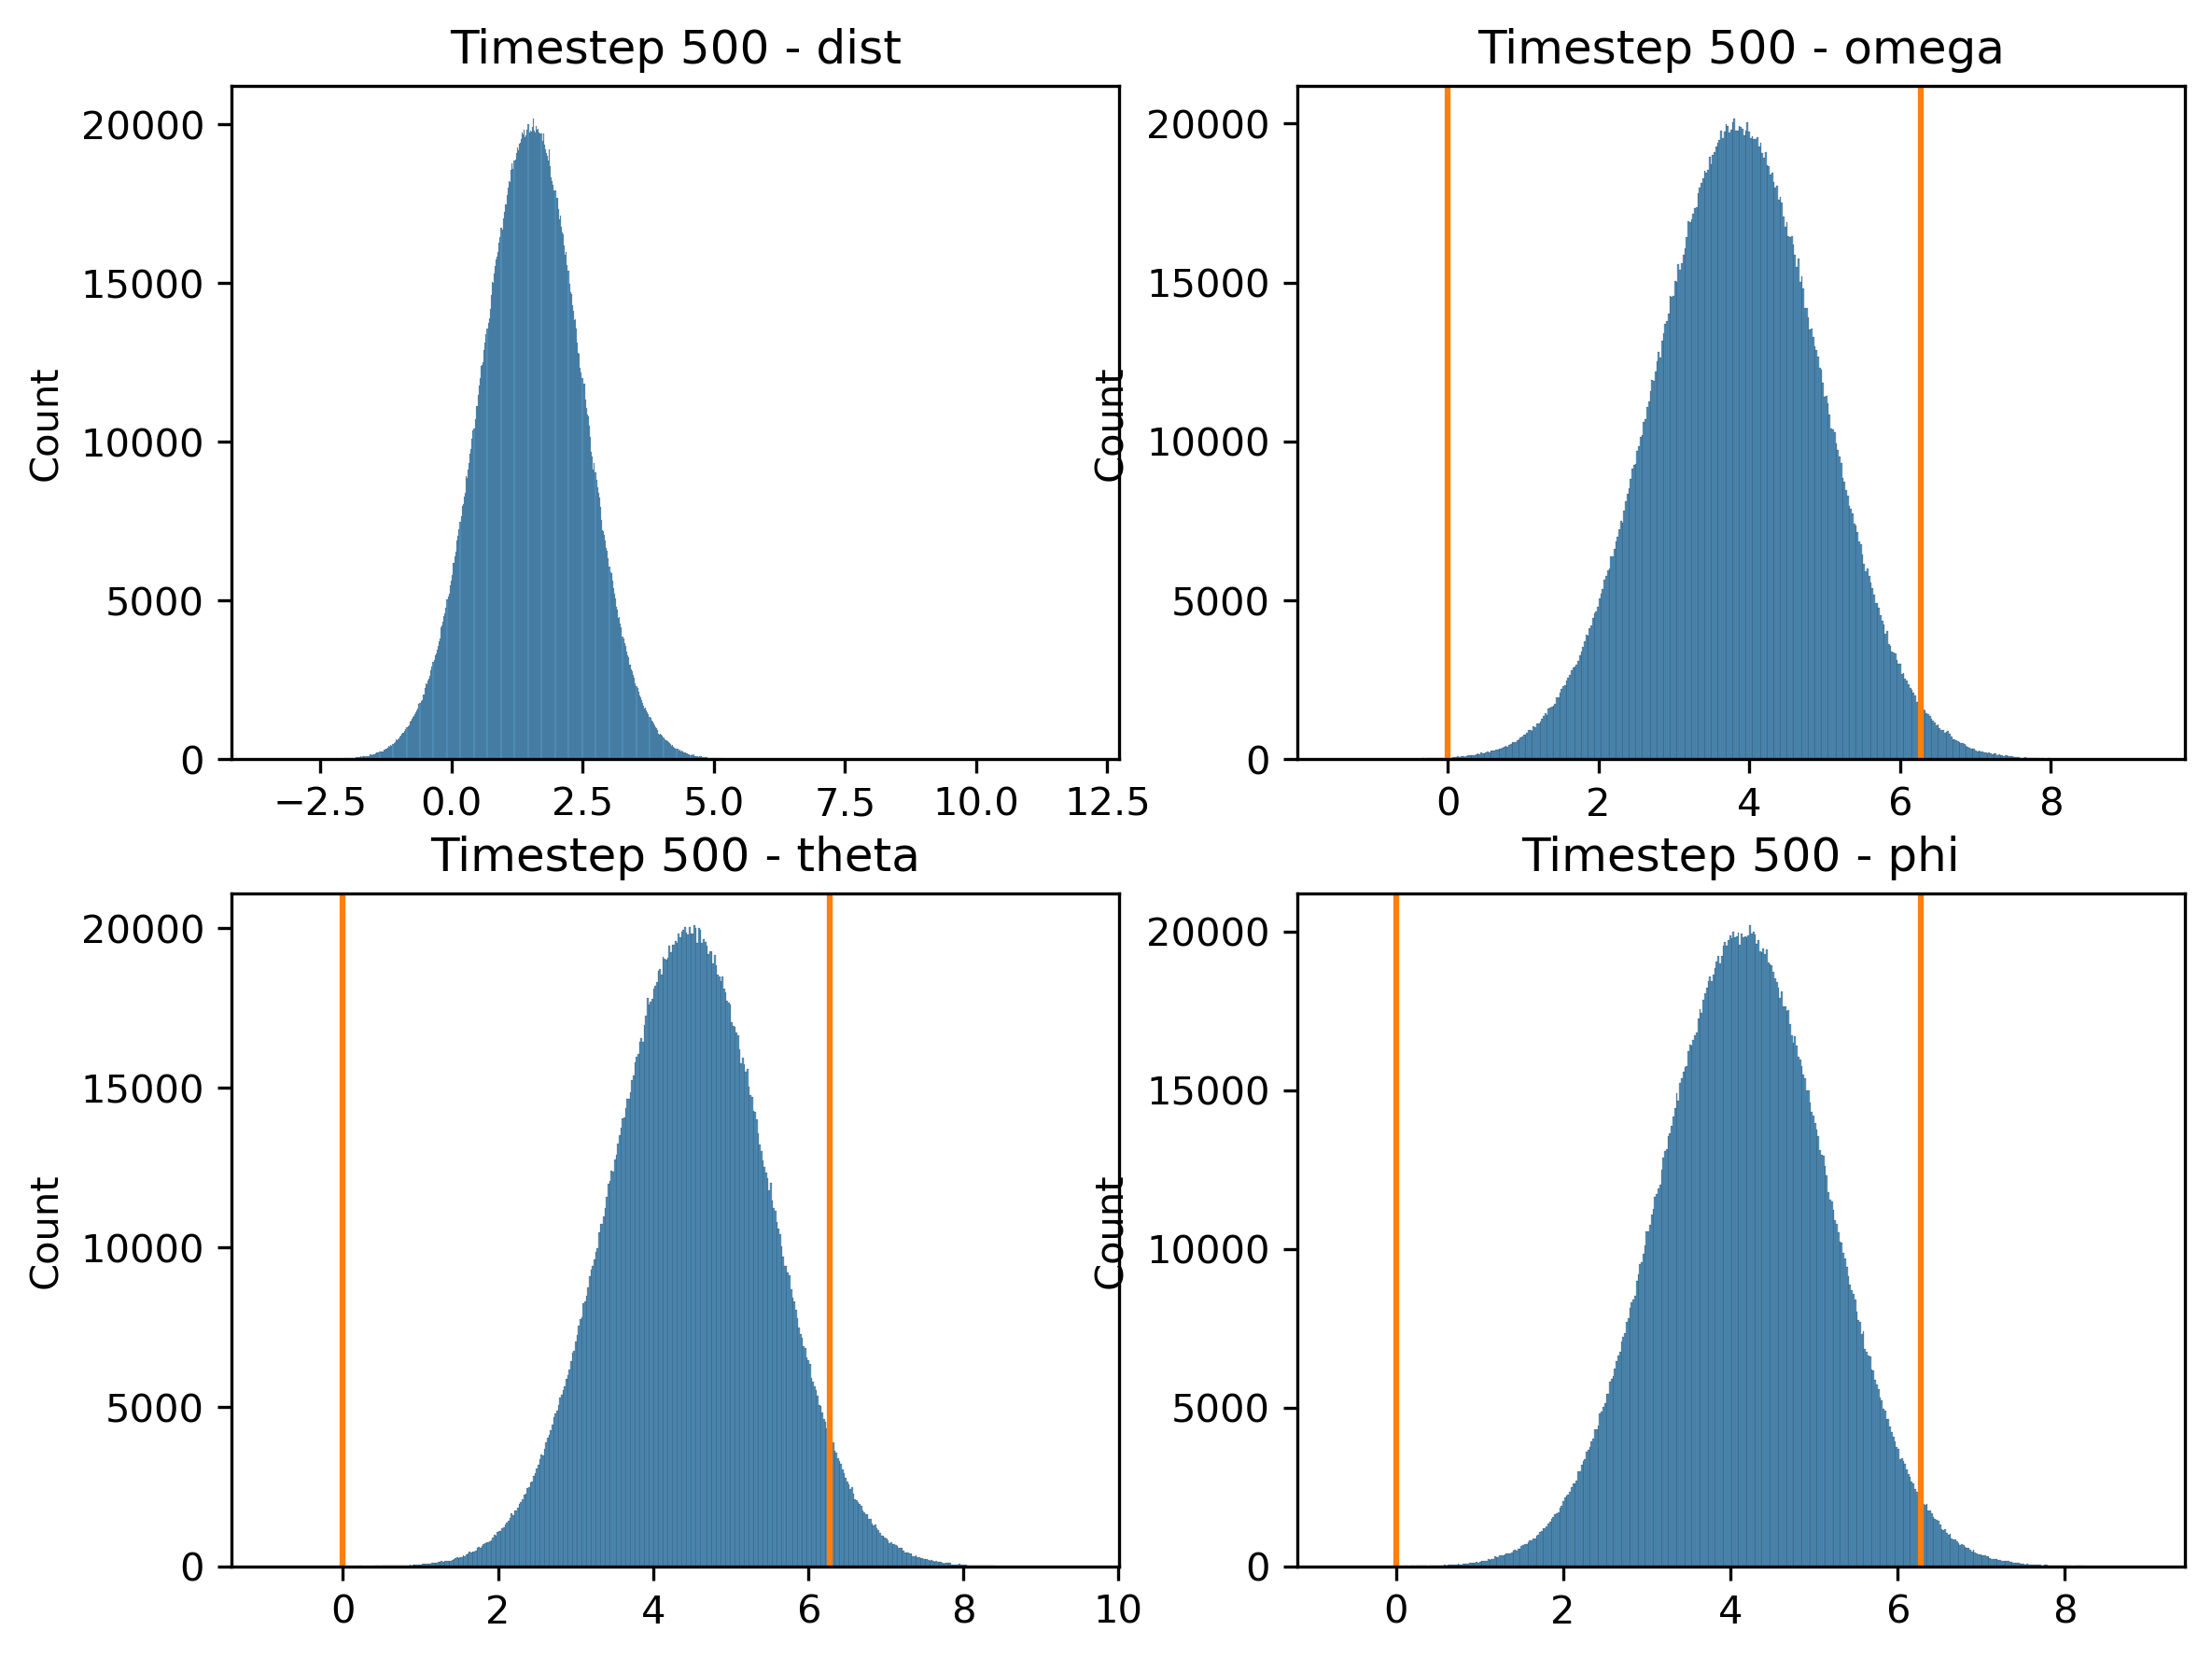

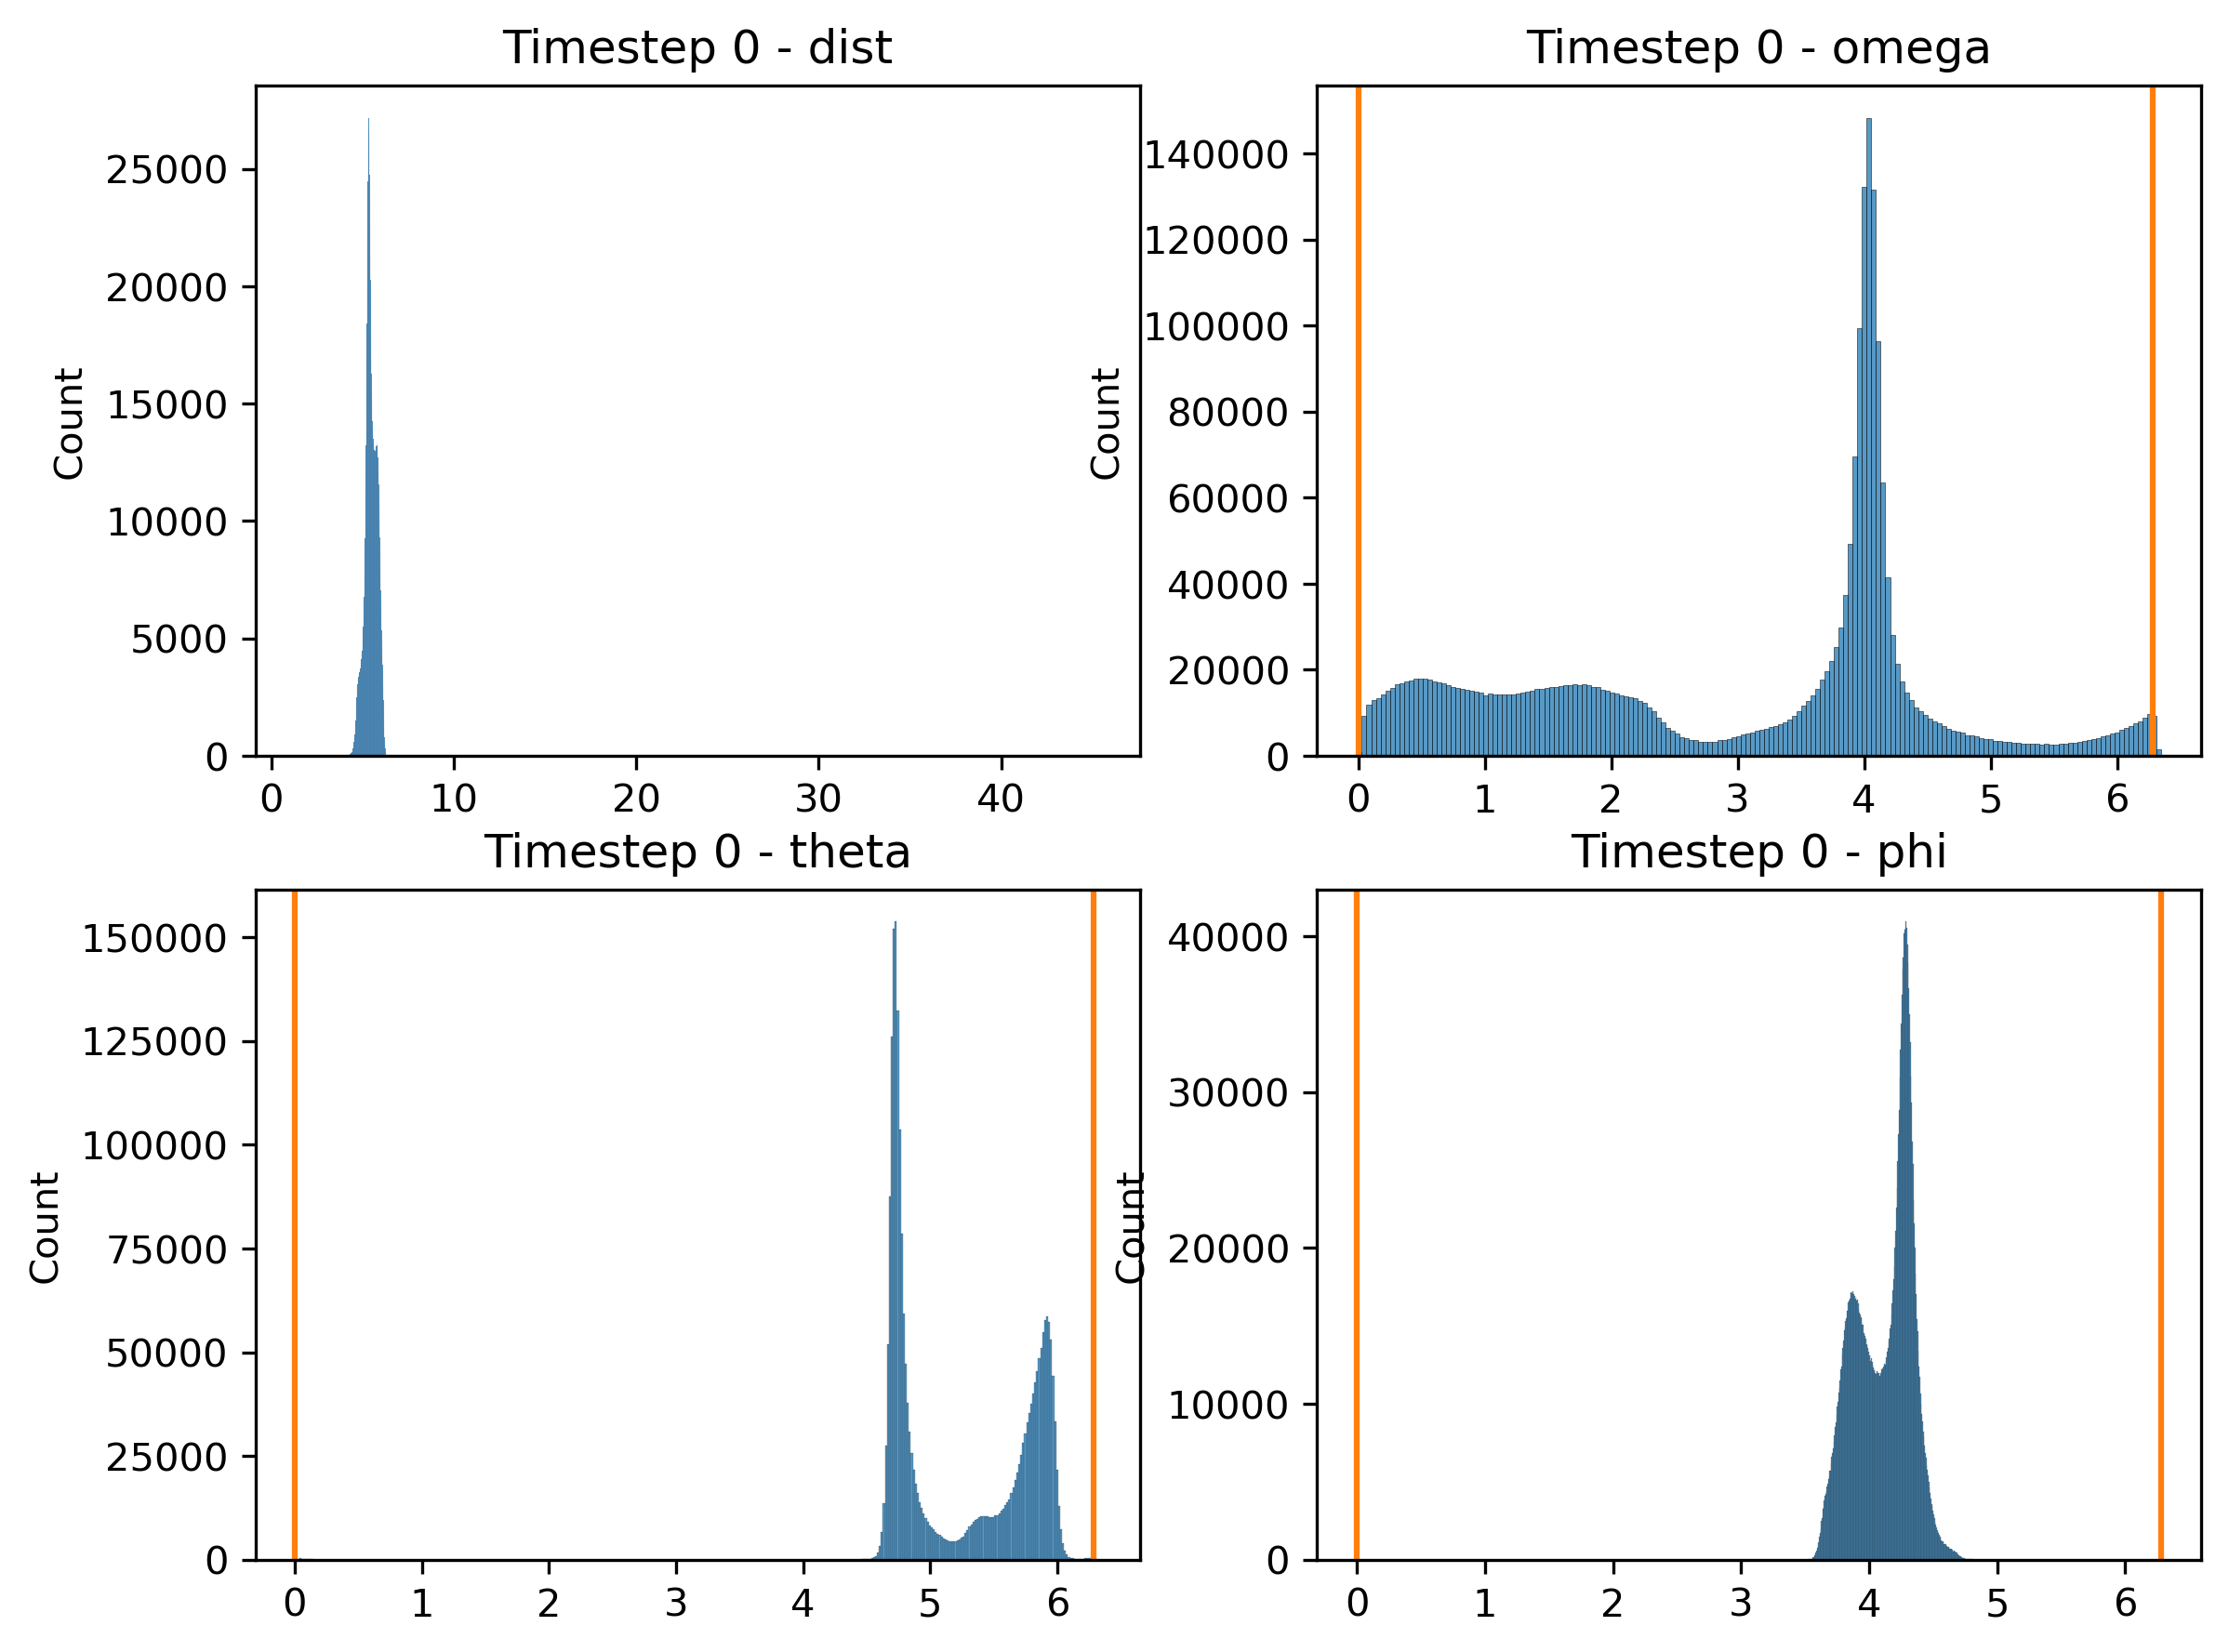

In [6]:
importlib.reload(datasets)

noised_dset = datasets.NoisedAnglesDataset(
    cath_dset,
    dset_key='angles',
    beta_schedule=params['variance_schedule'],
    timesteps=params['timesteps'],
    modulo=[0, 2 * np.pi, 2 * np.pi, 2 * np.pi],
    noise_by_modulo=True,
)

importlib.reload(plotting)
plotting.plot_val_dists_at_t(
    noised_dset,
    t=999,
    share_axes=False,
).show()

plotting.plot_val_dists_at_t(
    noised_dset,
    t=500,
    share_axes=False,
).show()

plotting.plot_val_dists_at_t(
    noised_dset,
    t=0,
    share_axes=False,
).show()

In [7]:
importlib.reload(sample_bin)
importlib.reload(sampling)
importlib.reload(utils)

sampled_proteins = sample_bin.sample(
    128,
    cath_dset,
    model_path=glob.glob(os.path.join(MODEL_DIR, "lightning_logs/version_0/checkpoints/*.ckpt")).pop(),  # Get the single checkpoint
    bert_cfg_path=os.path.join(MODEL_DIR, "config.json"),
    config_json=os.path.join(MODEL_DIR, "training_args.json"),
)
len(sampled_proteins)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmphqqj5h8n
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmphqqj5h8n/_remote_module_non_scriptable.py
INFO:root:Using loss: <function smooth_l1_loss at 0x7f719bf584c0>
INFO:root:Getting linear variance schedule with 1000 timesteps
INFO:root:Sampling of shape (128, 512, 4) with modulo tensor([0.0000, 6.2832, 6.2832, 6.2832])
INFO:root:Starting from noise with modulo tensor([0.0000, 6.2832, 6.2832, 6.2832]) and range tensor([-4.5467e+00,  2.3794e-05,  5.8384e-06,  7.7799e-06], device='cuda:0') - tensor([4.0157, 6.2832, 6.2831, 6.2831], device='cuda:0')


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

128

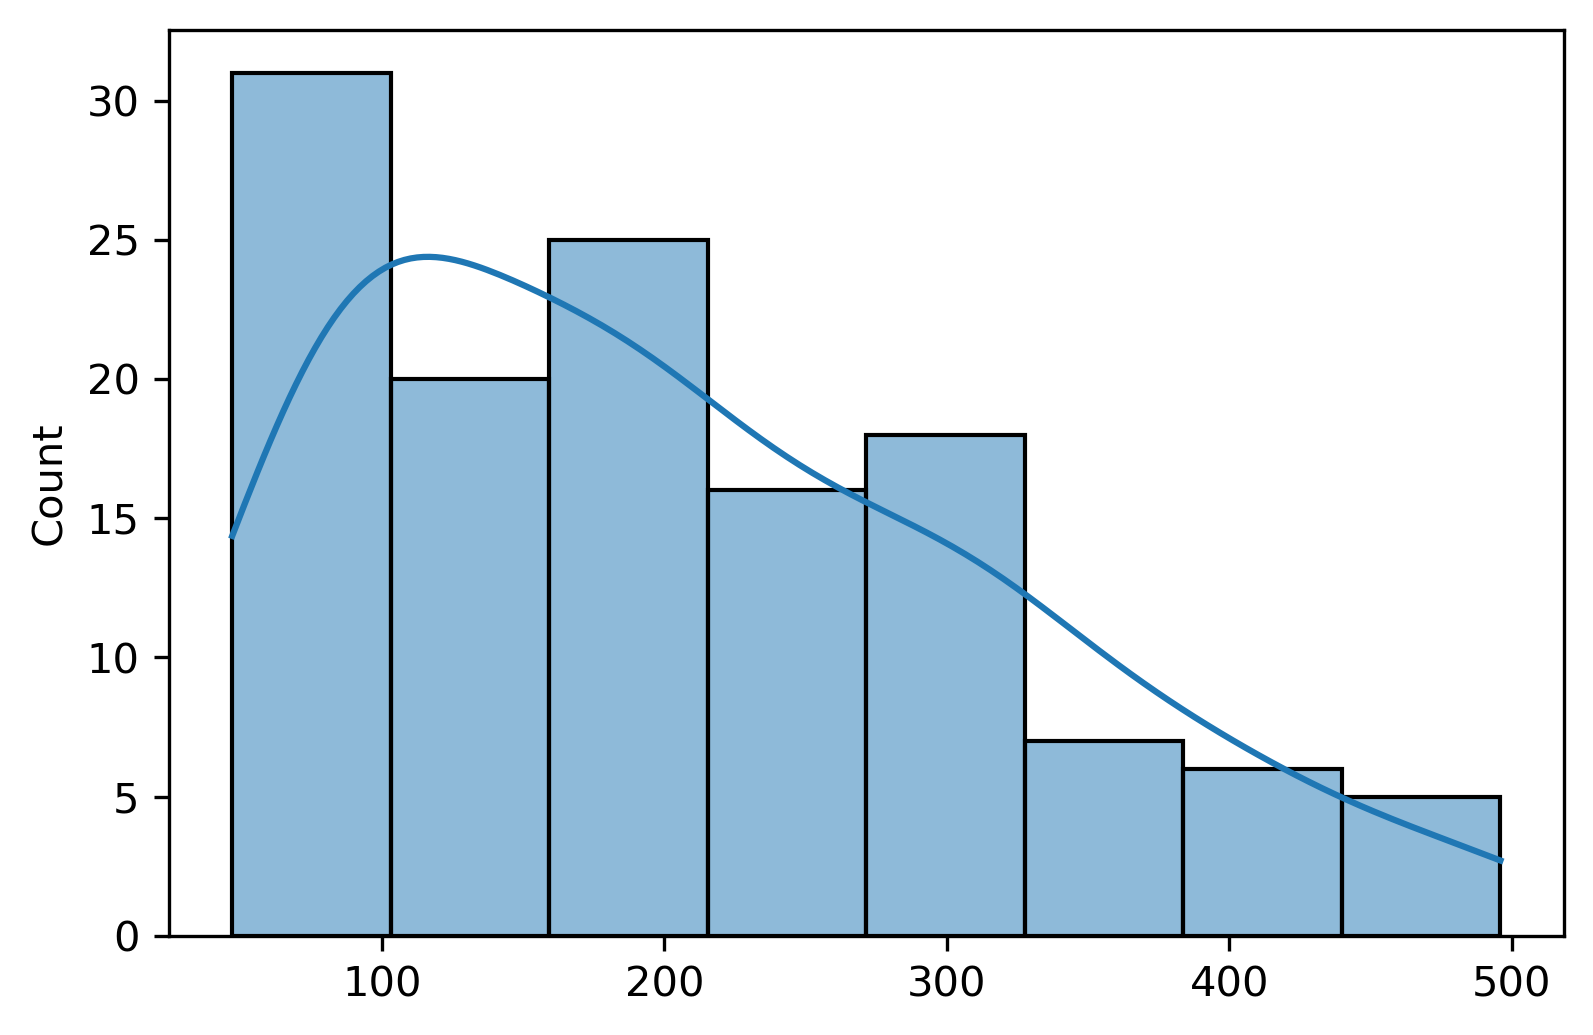

In [8]:
# Plot the distribution of lenghts of sampled proteins
fig, ax = plt.subplots(dpi=300)
sns.histplot([s.shape[0] for s in sampled_proteins], ax=ax, kde=True)
fig.show()

In [9]:
sampled_proteins_flat = torch.vstack(sampled_proteins) # Flatten to 1D
sampled_proteins_flat.shape

torch.Size([26253, 4])

In [10]:
sampled_proteins_flat

tensor([[5.4308, 5.9078, 3.5429, 1.8034],
        [5.4760, 0.5190, 2.5686, 1.3949],
        [5.1130, 3.4170, 2.7021, 1.6332],
        ...,
        [5.4299, 3.1043, 2.8827, 1.7570],
        [5.0932, 5.9356, 2.9930, 1.7997],
        [5.1211, 4.7143, 2.7833, 1.4862]])

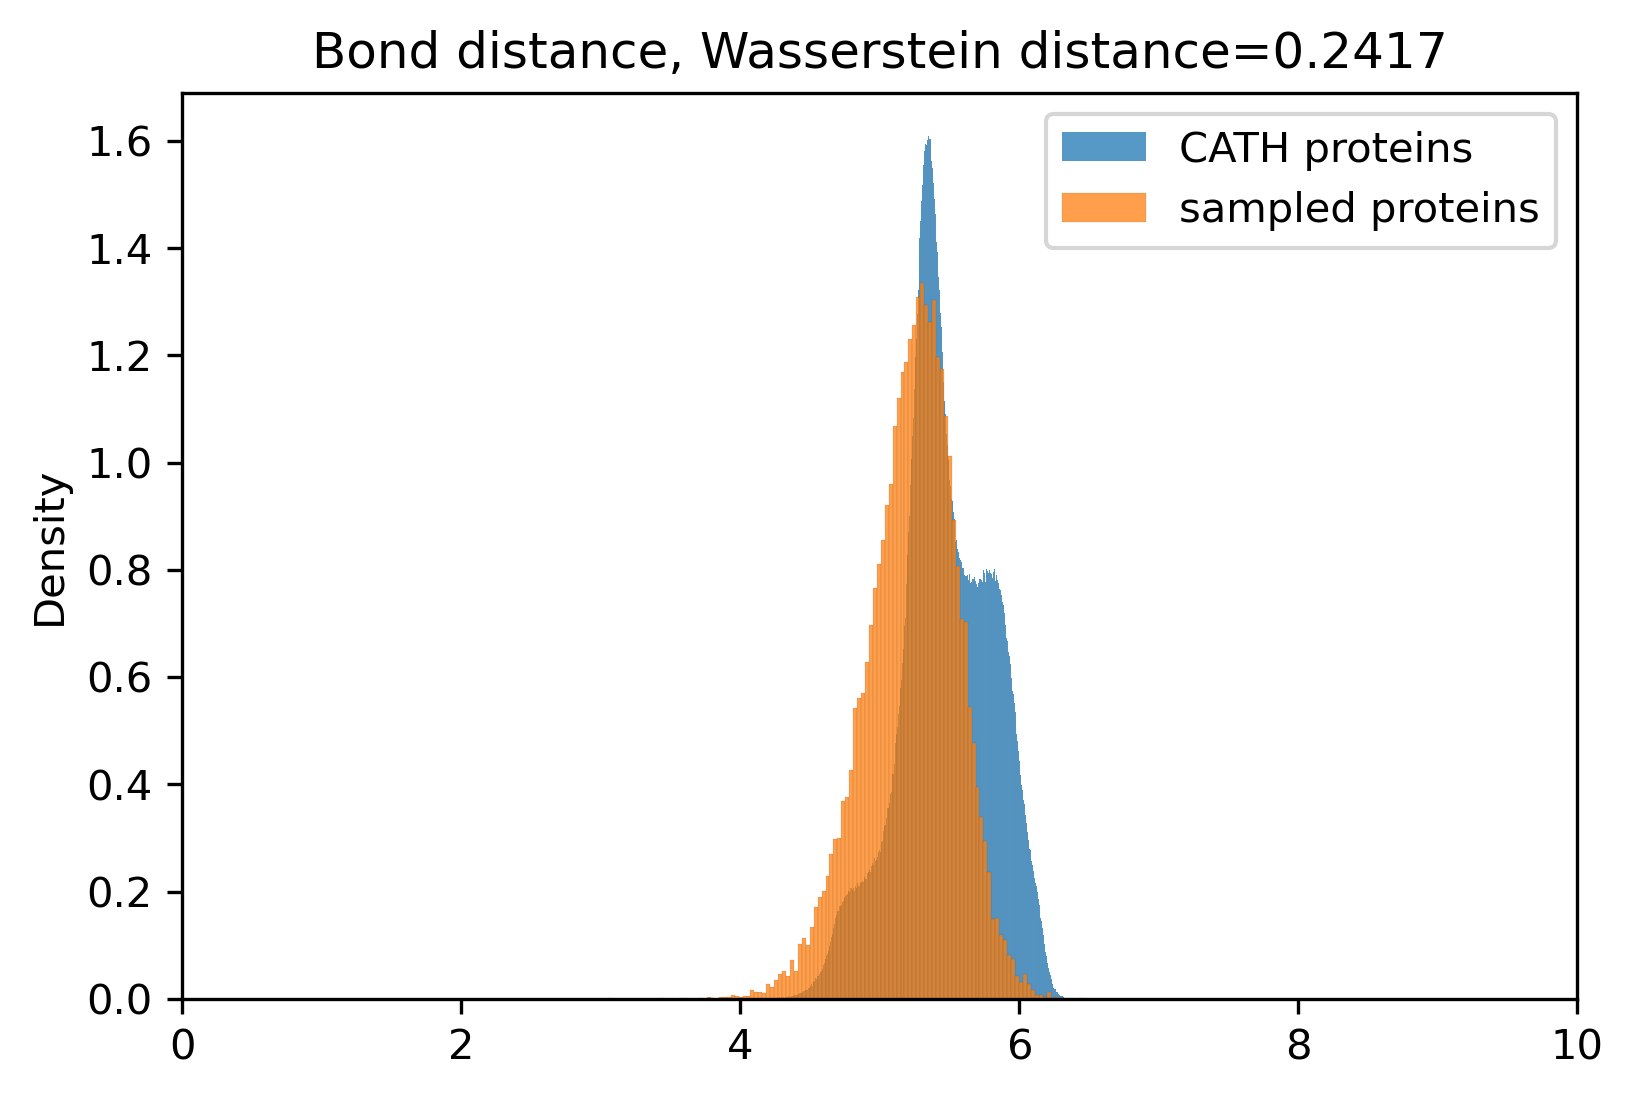

In [15]:
wd = stats.wasserstein_distance(sampled_proteins_flat[:, 0], cath_dset_values[:, 0])
fig, ax = plt.subplots(dpi=300)
sns.histplot(cath_dset_values[:, 0], stat='density', label="CATH proteins", ax=ax, color='tab:blue')
sns.histplot(sampled_proteins_flat[:, 0], stat='density', label='sampled proteins', ax=ax, color='tab:orange')
ax.legend()
ax.set(
    xlim=(0, 10),
    title=f"Bond distance, Wasserstein distance={wd:.4f}",
)
fig.show()

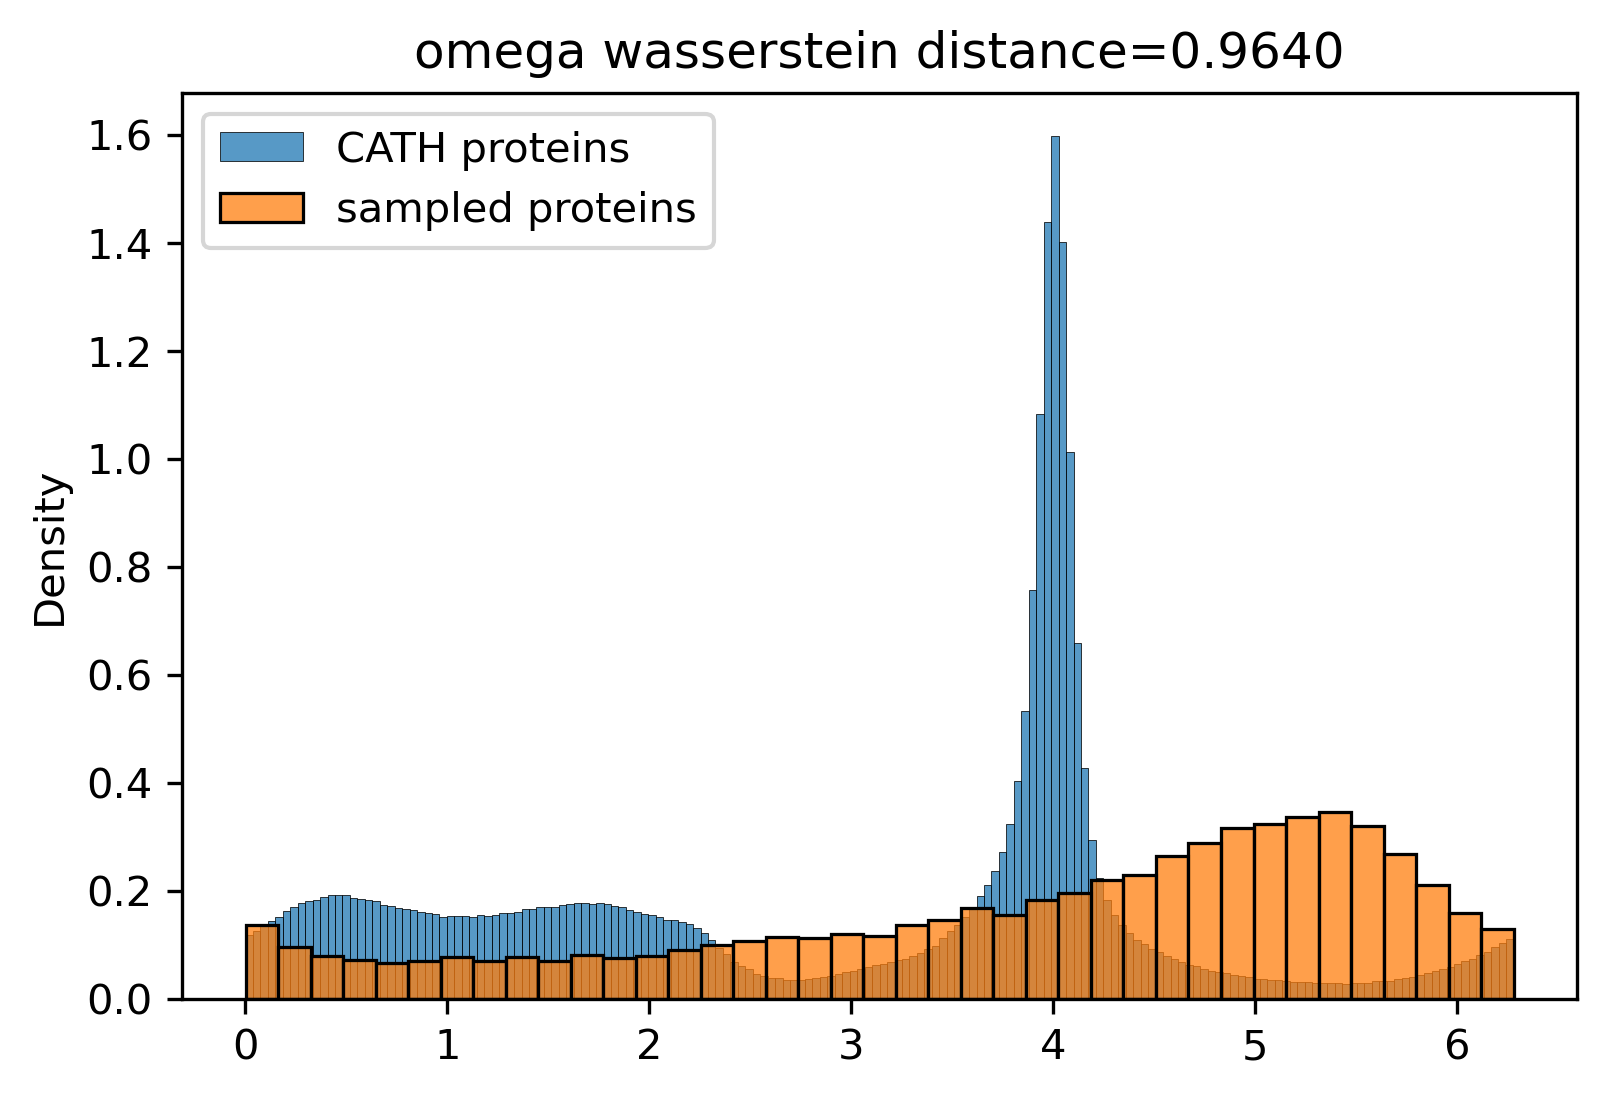

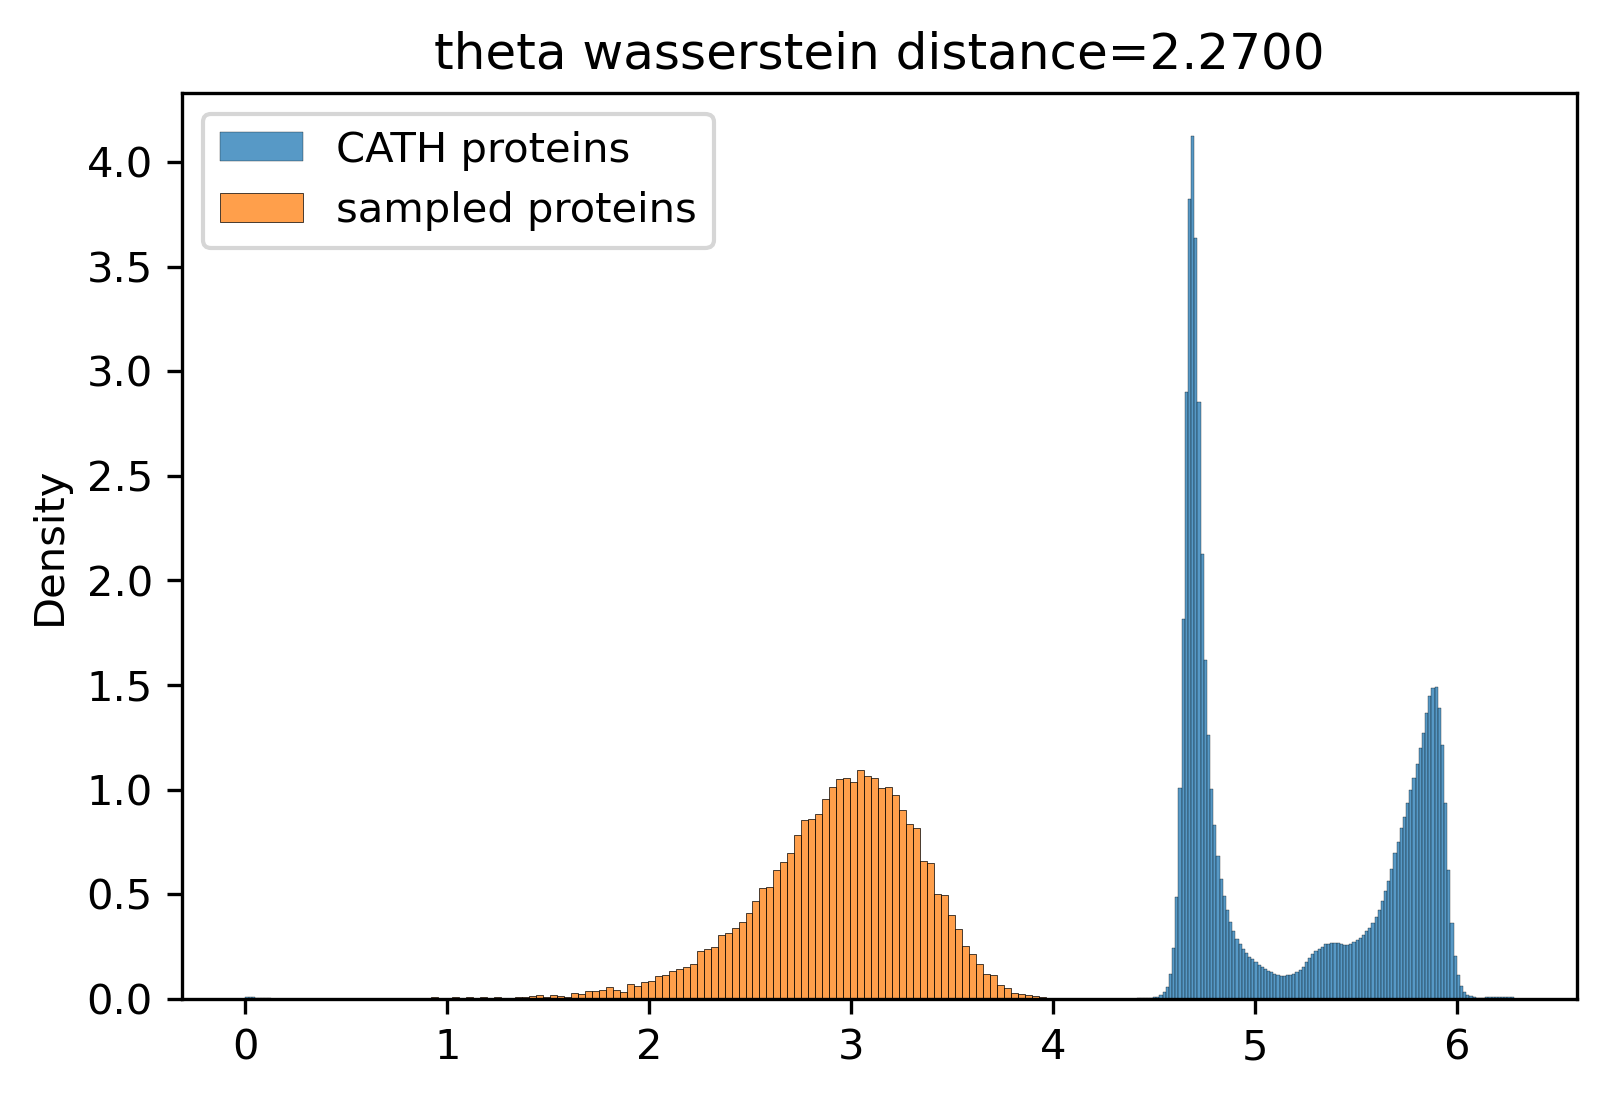

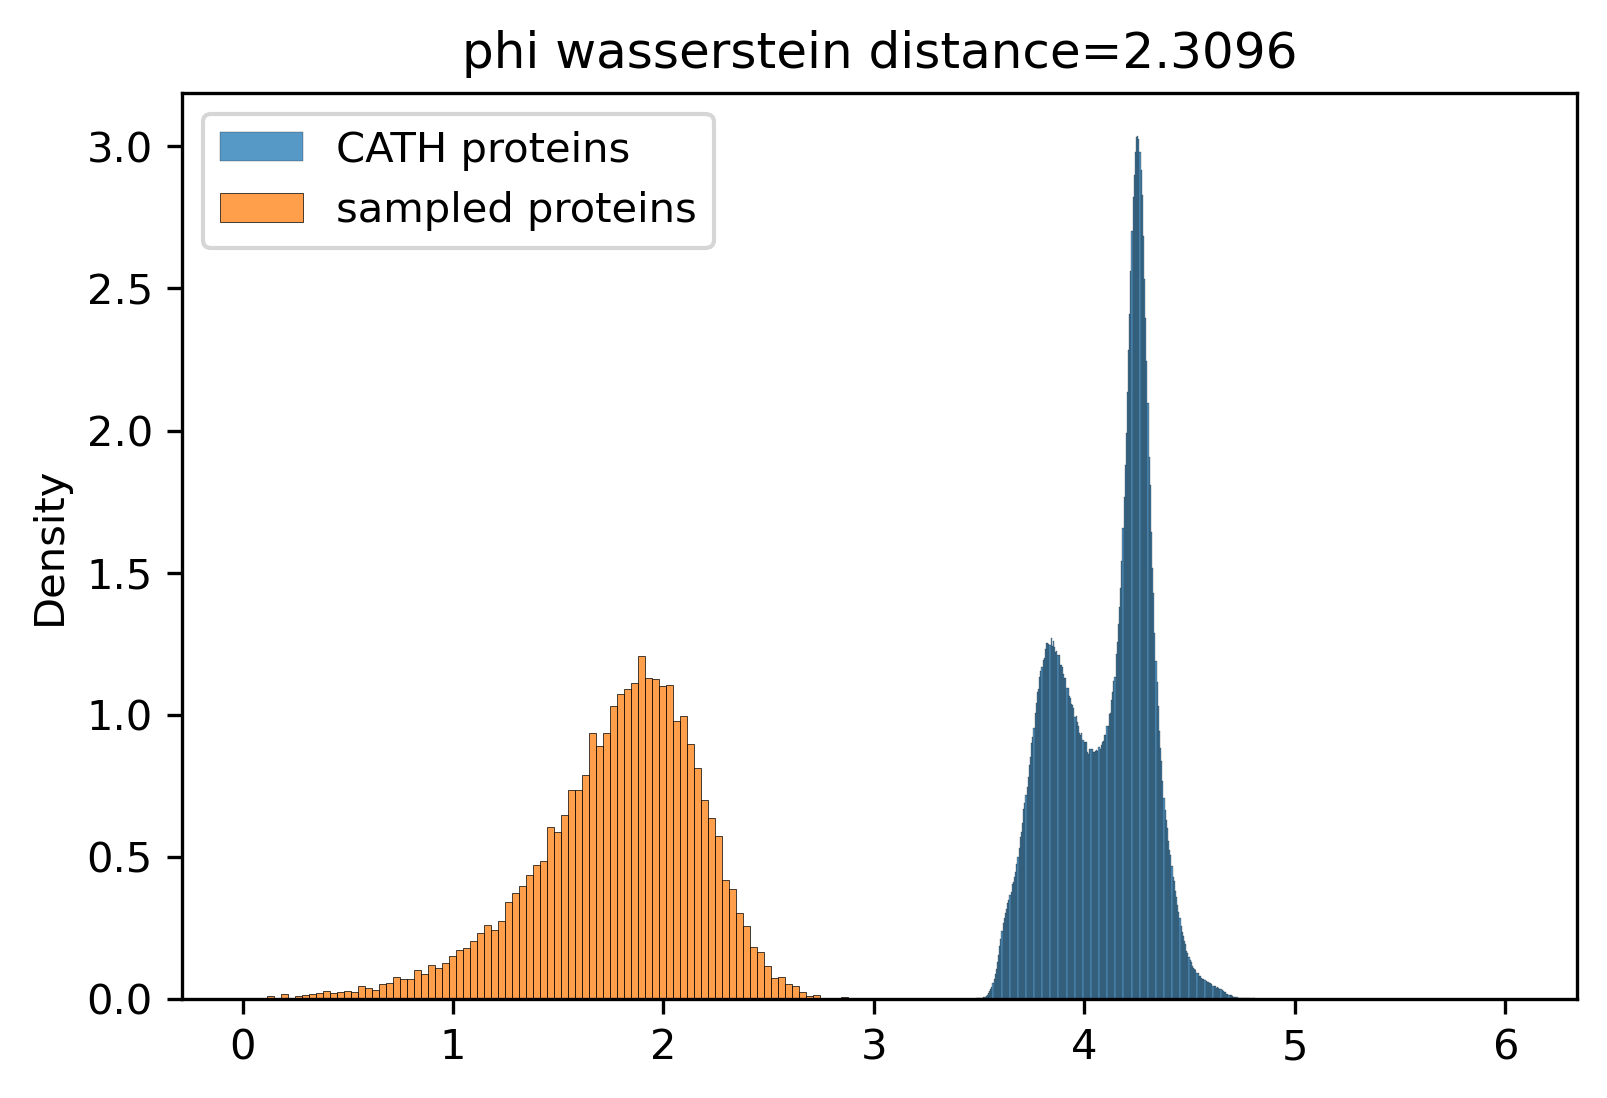

In [16]:
for i in range(1, 4):
    fig, ax = plt.subplots(dpi=300)
    wd = stats.wasserstein_distance(sampled_proteins_flat[:, i], cath_dset_values[:, i])
    sns.histplot(cath_dset_values[:, i], stat='density', label="CATH proteins", ax=ax, color='tab:blue')
    sns.histplot(sampled_proteins_flat[:, i] % (2 * np.pi), stat='density', label='sampled proteins', ax=ax, color='tab:orange')
    ax.legend()
    ax.set(
        # xlim=(-math.pi, math.pi),
        title=['omega', 'theta', 'phi'][i-1] + " wasserstein distance=" + f"{wd:.4f}",
    )
    fig.show()